In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt 

from sklearn import metrics
from sklearn import preprocessing
from linearmodels.system import SUR
from sklearn.decomposition import PCA 
from scipy.stats import boxcox, shapiro
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale,StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

### DATA

In [2]:
dataset = pd.read_excel("data/Dataset_SUR.xlsx")
dataset.head(10)

,Provinsi,Tahun,IPM,PDRB_PerKapita,JPM,Avr_LamaSekolah,Avr_AHH,TPT,UMR
0,ACEH,2020,73.29,31633,1648.82,9.33,69.975,5.995,3165031
1,SUMATERA UTARA,2020,73.62,54979,2640.01,9.54,69.150,5.810,2499423
2,SUMATERA BARAT,2020,74.29,43826,709.02,8.99,69.520,6.065,2484041
3,RIAU,2020,73.67,114167,974.61,9.14,71.650,5.620,2888564
4,JAMBI,2020,72.29,57958,565.90,8.55,71.170,4.695,2630162
5,SUMATERA SELATAN,2020,71.62,53843,2201.23,8.24,69.930,4.705,3043111
6,BENGKULU,2020,72.93,36552,608.58,8.84,69.370,3.575,2213604
7,LAMPUNG,2020,71.04,39290,2140.46,8.05,70.695,4.465,2432002
8,KEP. BANGKA BELITUNG,2020,72.74,52023,140.44,8.06,70.680,4.300,3230024
9,KEP. RIAU,2020,77.69,123465,274.58,10.12,69.990,8.160,3005460


In [3]:
df = dataset.drop(columns=["Provinsi", "Tahun"])
df.head()

,IPM,PDRB_PerKapita,JPM,Avr_LamaSekolah,Avr_AHH,TPT,UMR
0,73.29,31633,1648.82,9.33,69.975,5.995,3165031
1,73.62,54979,2640.01,9.54,69.150,5.810,2499423
2,74.29,43826,709.02,8.99,69.520,6.065,2484041
3,73.67,114167,974.61,9.14,71.650,5.620,2888564
4,72.29,57958,565.90,8.55,71.170,4.695,2630162


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IPM              102 non-null    float64
 1   PDRB_PerKapita   102 non-null    int64  
 2   JPM              102 non-null    float64
 3   Avr_LamaSekolah  102 non-null    float64
 4   Avr_AHH          102 non-null    float64
 5   TPT              102 non-null    float64
 6   UMR              102 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 5.7 KB


### Eksplorasi

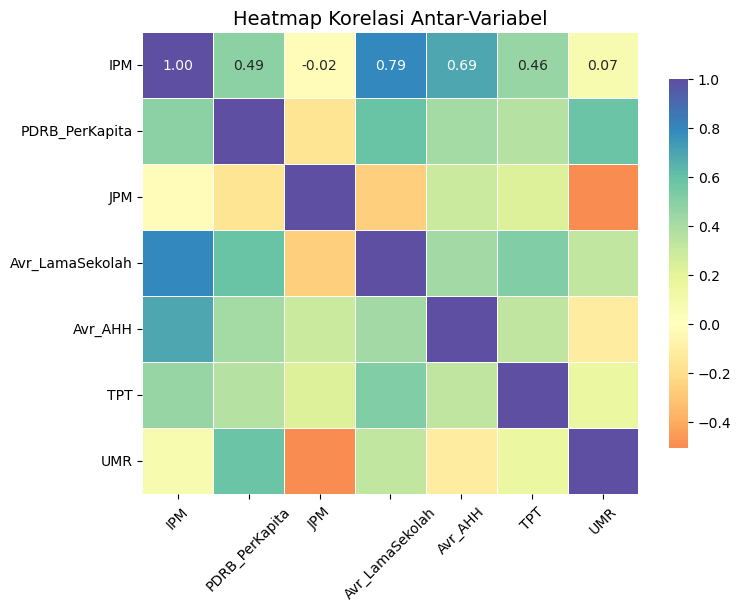

In [5]:
plt.figure(figsize=(8, 6))  # Ukuran grafik sedikit diperbesar untuk kejelasan
sns.heatmap(df.corr(), 
            annot=True, 
            cmap='Spectral',  # Menggunakan colormap 'Spectral'
            center=0, 
            linewidths=0.5, 
            fmt='.2f',  # Format angka dalam heatmap
            annot_kws={"size": 10},  # Menyesuaikan ukuran teks
            cbar_kws={"shrink": 0.8})  # Menyesuaikan ukuran color bar
plt.title('Heatmap Korelasi Antar-Variabel', fontsize=14)
plt.xticks(fontsize=10, rotation=45)  # Memutar label sumbu x agar lebih terbaca
plt.yticks(fontsize=10)
plt.show()

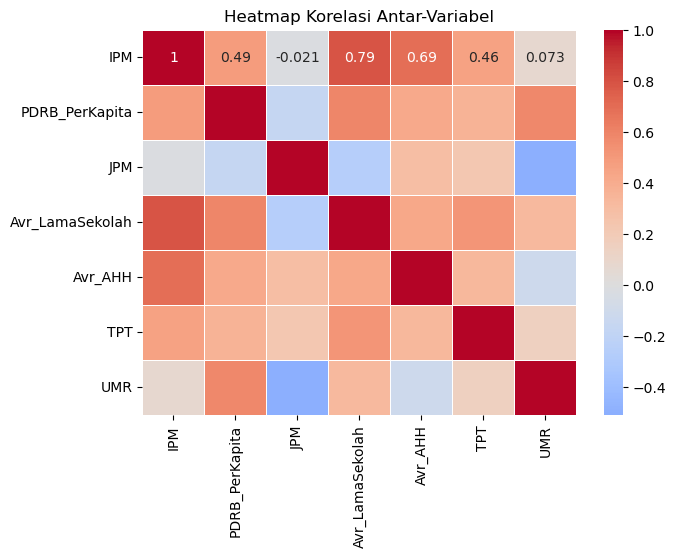

In [6]:
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Heatmap Korelasi Antar-Variabel')
plt.show()

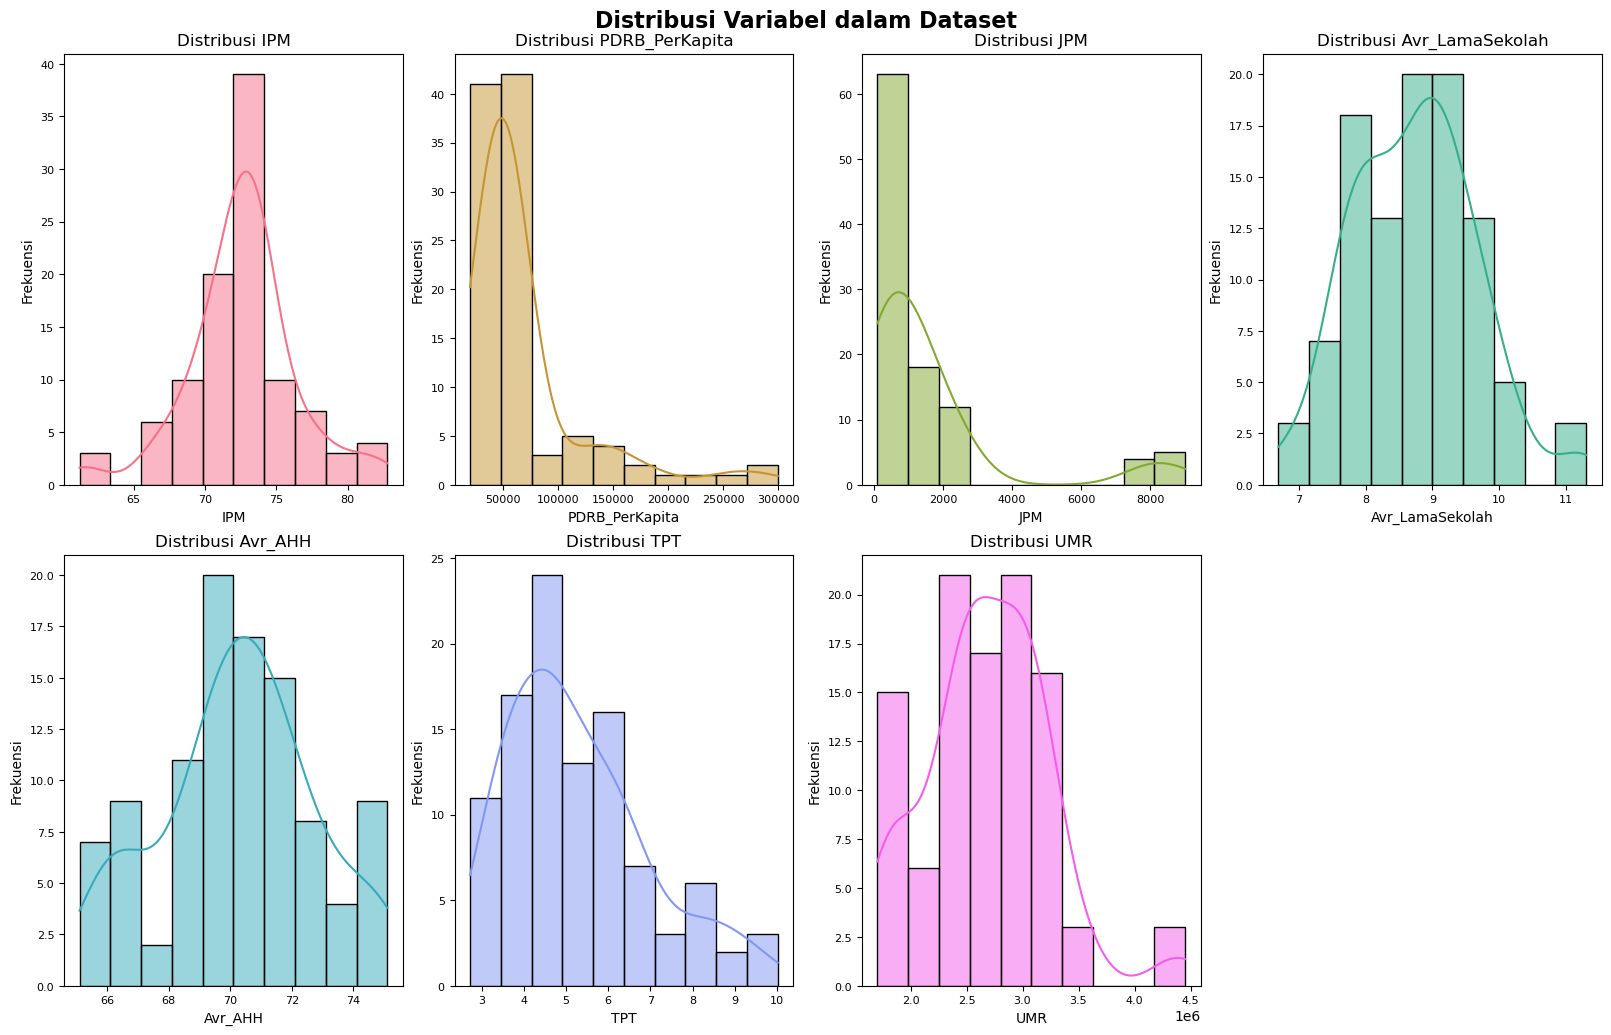

In [7]:
# Menentukan jumlah baris dan kolom untuk grid layout
n_cols = 4  # Jumlah kolom
n_rows = int(np.ceil(len(df.columns) / n_cols))  # Jumlah baris berdasarkan jumlah kolom

# Membuat subplots untuk histogram
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10), constrained_layout=True)

# Menghindari masalah jika jumlah variabel tidak genap dengan jumlah subplots
axes = axes.flatten()

# Iterasi melalui setiap kolom dalam DataFrame dan subplot
for i, col in enumerate(df.columns):
    sns.histplot(df[col], bins=10, kde=True, ax=axes[i], color=sns.color_palette("husl", len(df.columns))[i])
    axes[i].set_title(f'Distribusi {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frekuensi', fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

# Menyembunyikan subplot kosong (jika ada)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Menambahkan judul utama untuk seluruh grid
fig.suptitle('Distribusi Variabel dalam Dataset', fontsize=16, fontweight='bold', y=1.02)

# Menampilkan histogram
plt.show()


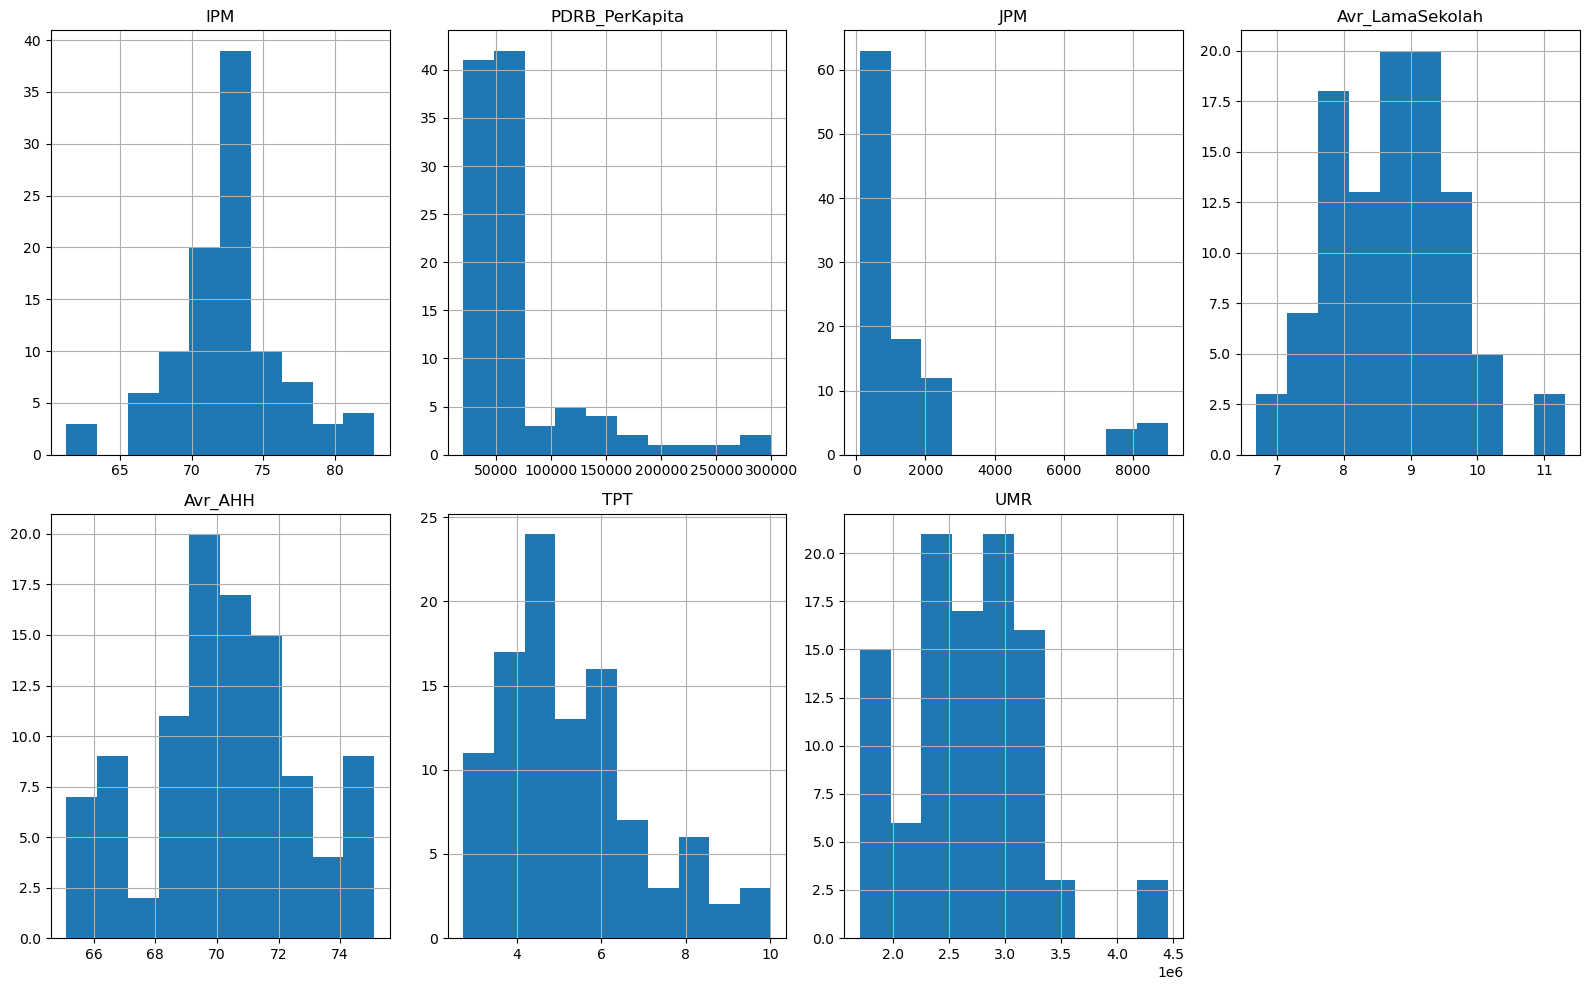

In [8]:
df.hist(bins=10, figsize=(16, 10), layout=(int(np.ceil(len(df.columns) / 4)), 4))
plt.tight_layout()
plt.show()

Kolom IPM - Shapiro-Wilk Test p-value: 0.0006
-> Kolom IPM tidak berdistribusi normal. Menerapkan transformasi Box-Cox.
   * Transformasi Box-Cox diterapkan untuk kolom IPM.
Kolom PDRB_PerKapita - Shapiro-Wilk Test p-value: 0.0000
-> Kolom PDRB_PerKapita tidak berdistribusi normal. Menerapkan transformasi Box-Cox.
   * Transformasi Box-Cox diterapkan untuk kolom PDRB_PerKapita.
Kolom JPM - Shapiro-Wilk Test p-value: 0.0000
-> Kolom JPM tidak berdistribusi normal. Menerapkan transformasi Box-Cox.
   * Transformasi Box-Cox diterapkan untuk kolom JPM.
Kolom Avr_LamaSekolah - Shapiro-Wilk Test p-value: 0.2821
Kolom Avr_AHH - Shapiro-Wilk Test p-value: 0.0524
Kolom TPT - Shapiro-Wilk Test p-value: 0.0001
-> Kolom TPT tidak berdistribusi normal. Menerapkan transformasi Box-Cox.
   * Transformasi Box-Cox diterapkan untuk kolom TPT.
Kolom UMR - Shapiro-Wilk Test p-value: 0.0013
-> Kolom UMR tidak berdistribusi normal. Menerapkan transformasi Box-Cox.
   * Transformasi Box-Cox diterapkan untuk 

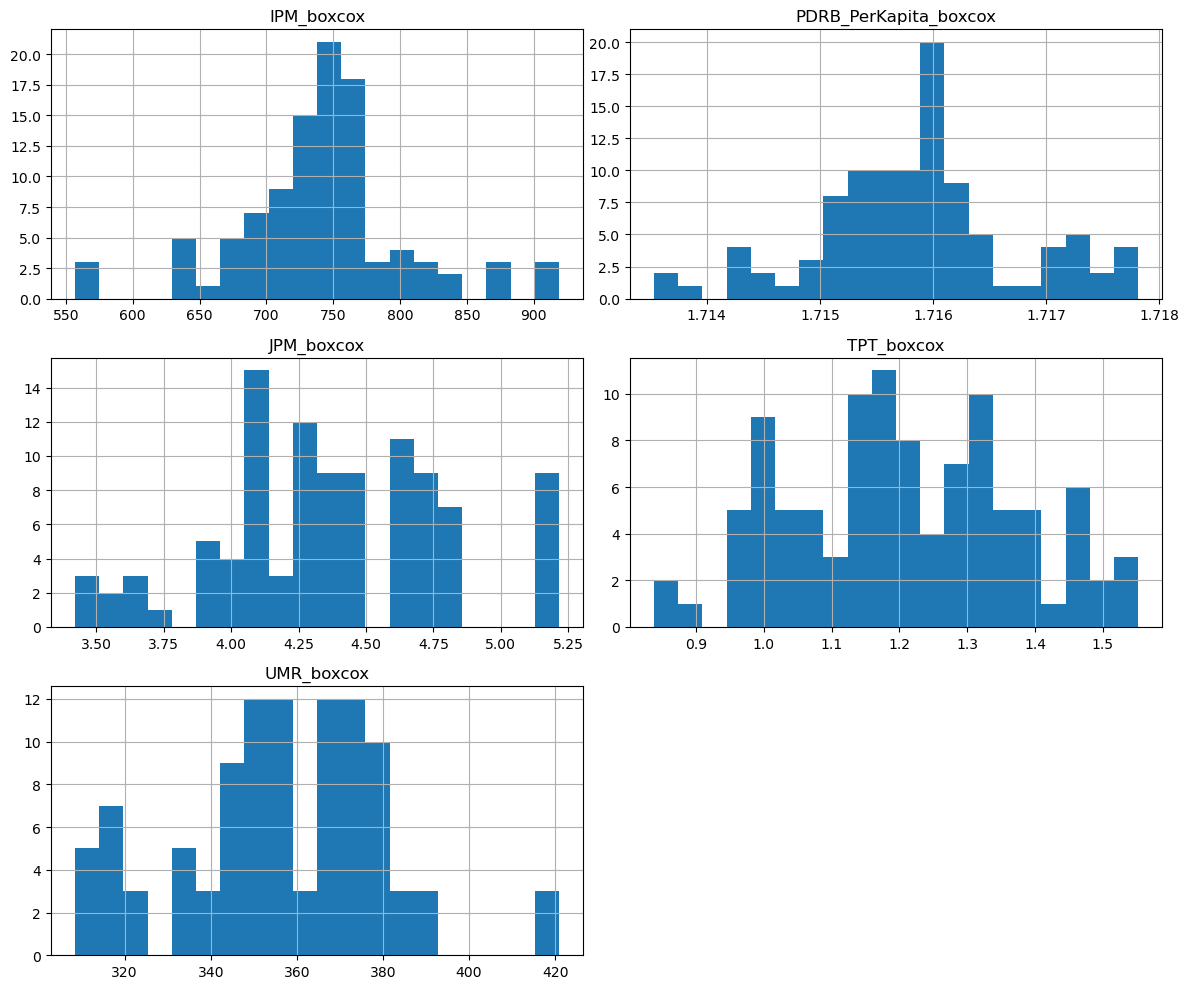

In [9]:
for column in df.columns:
    stat, p_value = shapiro(df[column].dropna())
    print(f"Kolom {column} - Shapiro-Wilk Test p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"-> Kolom {column} tidak berdistribusi normal. Menerapkan transformasi Box-Cox.")
        # Terapkan transformasi Box-Cox jika data positif
        if (df[column] > 0).all():
            df[column + '_boxcox'], _ = boxcox(df[column])
            print(f"   * Transformasi Box-Cox diterapkan untuk kolom {column}.")

# Menampilkan histogram untuk hasil transformasi Box-Cox
boxcox_columns = [col for col in df.columns if '_boxcox' in col]
df[boxcox_columns].hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()

### Pengecekan Asumsi Model 

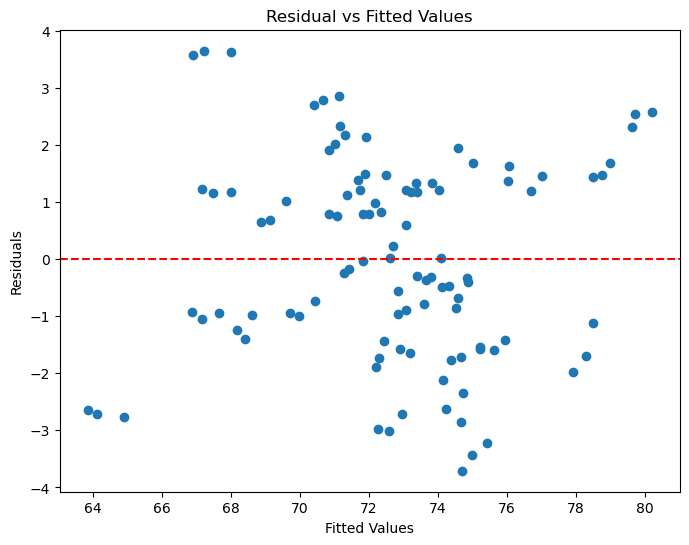


Variance Inflation Factor (VIF):
          Variable          VIF
0            const  1487.930326
1   PDRB_PerKapita     2.613042
2              JPM     2.129188
3  Avr_LamaSekolah     2.537715
4          Avr_AHH     1.872883
5              TPT     1.826546
6              UMR     2.393552


In [10]:
X = df[["PDRB_PerKapita","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]]
y = df["IPM"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# 1. Pengecekan Linearitas: plot residual vs fitted values
plt.figure(figsize=(8, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 4. Pengecekan Multikolinearitas: Menggunakan Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nVariance Inflation Factor (VIF):")
print(vif_data)

In [11]:
# Transformasi log pada variabel dependen
y_log = np.log(y)
model_log = sm.OLS(y_log, X).fit()

# Uji Breusch-Pagan untuk heteroskedastisitas
_, p_value_bp_log, _, _ = het_breuschpagan(model_log.resid, model_log.model.exog)
print(f'Uji Breusch-Pagan setelah log-transform: p-value = {p_value_bp_log}')
if p_value_bp_log > 0.05:
    print("Tidak terdapat heteroskedastisitas setelah transformasi log.")
else:
    print("Terdapat heteroskedastisitas setelah transformasi log.")

Uji Breusch-Pagan setelah log-transform: p-value = 0.015609240425580526
Terdapat heteroskedastisitas setelah transformasi log.


### WLS 

In [12]:
#Persamaan 1: Model WLS untuk IMP
y_IPM = df['IPM'] 
X_IPM = df[["PDRB_PerKapita","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]]  
X_IPM = sm.add_constant(X_IPM)  
weights = 1 / model.resid**2
model_IPM = sm.OLS(y_IPM, X_IPM)
results_IPM= sm.WLS(y_IPM, X_IPM, weights=weights).fit()
print(">>>>> Hasil Model OLS untuk IMP")
print(results_IPM.summary())
print("\n")

# Persamaan 2: Model WLS untuk PDRB
y_PDRB = df['PDRB_PerKapita']  # Variabel dependen
X_PDRB = df[["IPM","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]] 
X_IPM = sm.add_constant(X_IPM)  
weights = 1 / model.resid**2
model_PDRB = sm.OLS(y_PDRB, X_PDRB)
results_PDRB= sm.WLS(y_PDRB, X_PDRB, weights=weights).fit()
print(">>>>> Hasil Model OLS untuk PDRB")
print(results_PDRB.summary())

>>>>> Hasil Model OLS untuk IMP
                            WLS Regression Results                            
Dep. Variable:                    IPM   R-squared:                       0.989
Model:                            WLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1378.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           5.00e-90
Time:                        22:02:34   Log-Likelihood:                -152.23
No. Observations:                 102   AIC:                             318.5
Df Residuals:                      95   BIC:                             336.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const     

Melakukan uji kenormalan galat

In [13]:
korelasi = df[['IPM', 'PDRB_PerKapita']].corr()
print(korelasi)

# Menggunakan uji Granger Causality
grangercausalitytests(df[['IPM', 'PDRB_PerKapita']], maxlag=2)

                     IPM  PDRB_PerKapita
IPM             1.000000        0.493635
PDRB_PerKapita  0.493635        1.000000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3342  , p=0.5645  , df_denom=98, df_num=1
ssr based chi2 test:   chi2=0.3444  , p=0.5573  , df=1
likelihood ratio test: chi2=0.3438  , p=0.5576  , df=1
parameter F test:         F=0.3342  , p=0.5645  , df_denom=98, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1006  , p=0.9044  , df_denom=95, df_num=2
ssr based chi2 test:   chi2=0.2119  , p=0.8995  , df=2
likelihood ratio test: chi2=0.2116  , p=0.8996  , df=2
parameter F test:         F=0.1006  , p=0.9044  , df_denom=95, df_num=2


{1: ({'ssr_ftest': (0.33416879245061637, 0.5645405876404456, 98.0, 1),
   'ssr_chi2test': (0.3443984493623699, 0.5573012899869799, 1),
   'lrtest': (0.3438126011053555, 0.5576367400435702, 1),
   'params_ftest': (0.33416879245074466, 0.5645405876403691, 98.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.10063420267914455, 0.9043600156657453, 95.0, 2),
   'ssr_chi2test': (0.21186147932451482, 0.899486944688141, 2),
   'lrtest': (0.21163736937171507, 0.899587742323833, 2),
   'params_ftest': (0.10063420268323678, 0.9043600156620509, 95.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

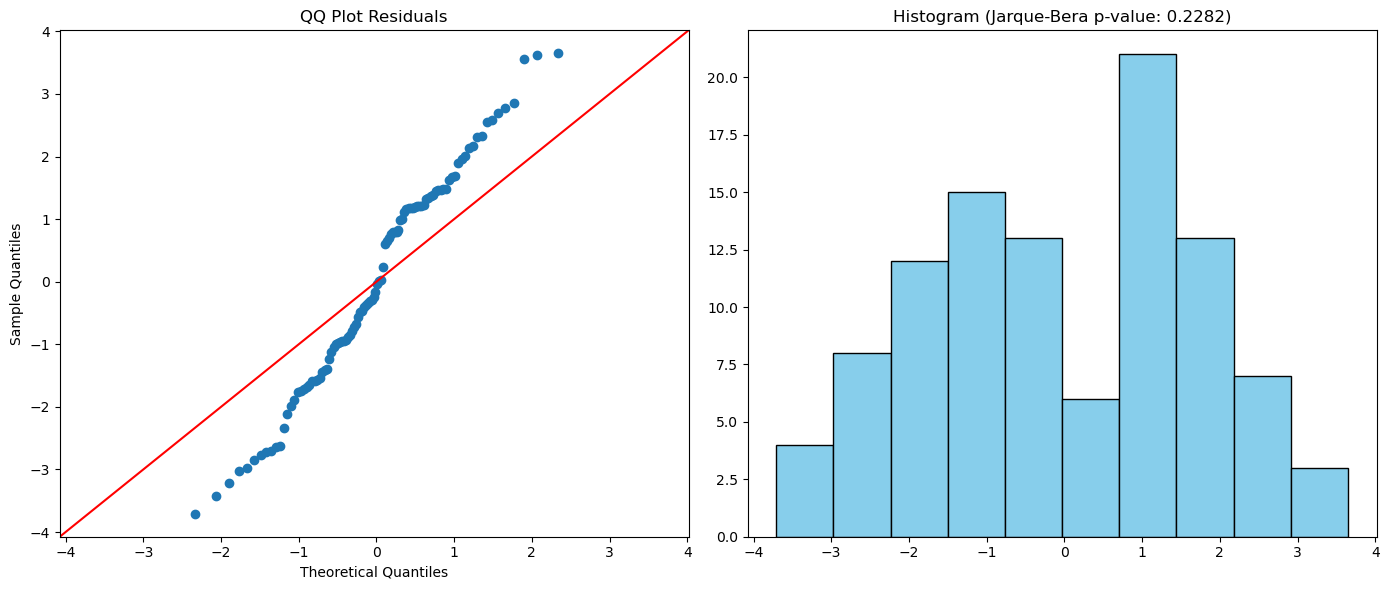

Jarque-Bera Test: Statistic = 2.9546798291858813, p-value = 0.22824403017971848


In [14]:
X = df[["PDRB_PerKapita","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]]
y = df['IPM']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
residuals = model.resid

# 1. Uji Kenormalan dengan QQ Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sm.qqplot(residuals, line ='45', ax=ax[0])
ax[0].set_title('QQ Plot Residuals')

# 2. Uji Jarque-Bera
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
ax[1].hist(residuals, bins=10, color='skyblue', edgecolor='black')
ax[1].set_title(f'Histogram (Jarque-Bera p-value: {jb_pvalue:.4f})')
plt.tight_layout()
plt.show()

print(f"Jarque-Bera Test: Statistic = {jb_stat}, p-value = {jb_pvalue}")

Melakukan uji korelasi kesebayaan antar galat.

In [15]:
# Definisikan variabel independen dan dependen
X = df[["PDRB_PerKapita","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]]
y = df['IPM']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
residuals = model.resid

# 1. Uji Durbin-Watson untuk autokorelasi
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

# 2. Korelasi antar residual yang bergeser (lagged residuals)
lagged_residuals = residuals.shift(1).dropna()  # Menggeser residual untuk mendapatkan lag
current_residuals = residuals.iloc[1:]  # Mengambil residual yang dimulai dari indeks ke-1
correlation = current_residuals.corr(lagged_residuals)
print(f"Correlation between current and lagged residuals: {correlation}")

Durbin-Watson Statistic: 1.5209578928497867
Correlation between current and lagged residuals: 0.2300191921672725


### Menyusun model SUR

In [16]:
formula = {
    'IPM_eq': "IPM ~ PDRB_PerKapita + JPM + Avr_LamaSekolah + Avr_AHH + TPT + UMR",
    'PDRB_eq': "PDRB_PerKapita ~ IPM + JPM + Avr_LamaSekolah + Avr_AHH + TPT + UMR"}
model = SUR.from_formula(formula, data=df)
result = model.fit()
print(result.summary)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.7831
No. Equations.:                     2   McElroy's R-squared:                 0.6772
No. Observations:                 102   Judge's (OLS) R-squared:             0.4248
Date:                Fri, Nov 29 2024   Berndt's R-squared:                  0.8352
Time:                        22:02:35   Dhrymes's R-squared:                 0.7831
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                     Equation: IPM_eq, Dependent Variable: IPM                     
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
PDRB_PerKapita  -5.483e-06  4.832e-06    -1.1347     0.2565  -1.495e-05   3.

In [20]:
residuals = result.resids
residual_IPM = residuals['IPM_eq']
residual_PDRB = residuals['PDRB_eq']

correlation_IPM_PDRB = np.corrcoef(residual_IPM, residual_PDRB)[0, 1]
correlation_PDRB_IPM = np.corrcoef(residual_PDRB, residual_IPM)[0, 1]


print(f'Korelasi antara residual IPM dan PDRB: {correlation_IPM_PDRB:.4f}')
print(f'Korelasi antara residual PDRB dan IPM : {correlation_PDRB_IPM:.4f}')


Korelasi antara residual IPM dan PDRB: 0.1873
Korelasi antara residual PDRB dan IPM : 0.1873


Uji Kesesuaian Model 

In [18]:
X = df[["PDRB_PerKapita","JPM","Avr_LamaSekolah","Avr_AHH", "TPT", "UMR"]]
y = df['IPM']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print(model.summary())

# Uji F untuk keseluruhan model (lihat bagian Prob (F-statistic) pada ringkasan)
f_statistic = model.f_pvalue
print(f'Hasil Uji F (Signifikansi keseluruhan model): p-value = {f_statistic:.4f}\n')

# Uji t untuk masing-masing koefisien (lihat pada ringkasan model)
for variable, p_value in model.pvalues.items():
    print(f'Uji t untuk koefisien {variable}: p-value = {p_value:.4f}')

Hasil Uji F (Signifikansi keseluruhan model): p-value = 0.0000

Uji t untuk koefisien const: p-value = 0.2995
Uji t untuk koefisien PDRB_PerKapita: p-value = 0.9218
Uji t untuk koefisien JPM: p-value = 0.5538
Uji t untuk koefisien Avr_LamaSekolah: p-value = 0.0000
Uji t untuk koefisien Avr_AHH: p-value = 0.0000
Uji t untuk koefisien TPT: p-value = 0.7714
Uji t untuk koefisien UMR: p-value = 0.1448
